In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

In [2]:
#We call in the rv data we have.
df_raw = pd.read_csv('TIC 258804746_rv_unbin_newest.csv')

#We only take "bjd", "rv", "e_rv" and "tel" columns from the df_all as follows. (We basically remove other columns)
df = df_raw[['bjd','rv','e_rv']]

#Then we define those columns as "time", "mnvel", "errvel" and "tel" as follows.
df.columns = ['time','mnvel','errvel']

df

,time,mnvel,errvel
0,2.460662e+06,-8.980639,2.618923
1,2.460662e+06,-21.921024,3.141299
2,2.460664e+06,-1.938046,2.359089
3,2.460665e+06,6.412131,1.850221
4,2.460666e+06,9.844131,1.807651
5,2.460681e+06,-12.130043,4.233394
6,2.460681e+06,6.774739,2.815522
7,2.460686e+06,4.610357,5.800396
8,2.460726e+06,-1.362416,2.957234
9,2.460726e+06,-6.294036,2.703145


In [3]:
#We define a frequency range (which we convert from period range)
#For example, we do a search from 0.1 days to 100 days.
min_period, max_period = 0.1, 100

#We then define a frequency interval using the period interval.
frequency = np.linspace(1/max_period, 1/min_period, 10000)

In [4]:
#We then compute the Generalized Lomb-Scargle (GLS) Periodogram.
LS = LombScargle(df["time"], df["mnvel"], df["errvel"])
power = LS.power(frequency)

power

array([0.1512672 , 0.15377866, 0.16134087, ..., 0.07702689, 0.0711099 ,
       0.07226017])

In [5]:
#We then convert the frequency to period again for plotting.
periods = 1/frequency

#We then use the periods to find the best-fit period.
best_period = periods[np.argmax(power)]
best_power = np.max(power)

In [6]:
#We compute the %1 False Alarm Probability.
false_alarm = LS.false_alarm_level(0.01, method='bootstrap')

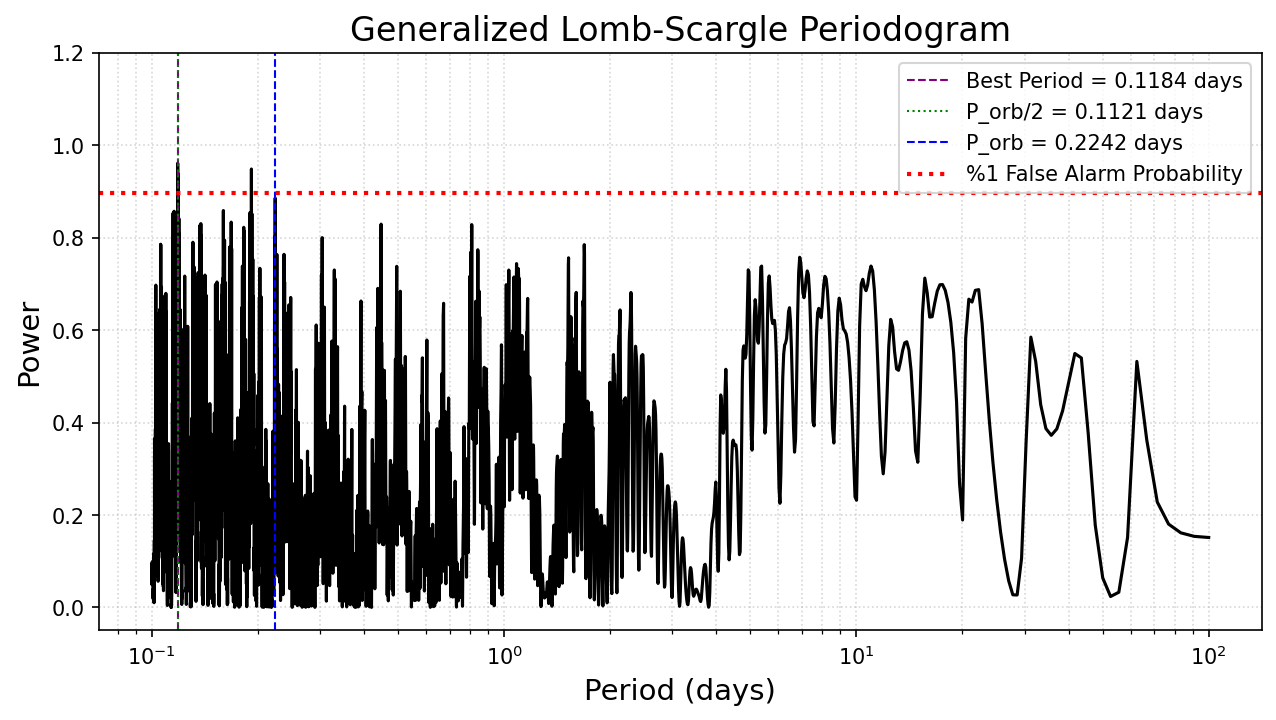

In [7]:
#We then plot the Generalized Lomb-Scargle periodogram.
fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)

ax.plot(periods, power, color = "black", lw = 1.5)
ax.axvline(best_period, color = "purple", linestyle = "dashed", lw = 1, label = f"Best Period = {best_period:.4f} days")
ax.axvline(best_period, color = "green", linestyle = "dotted", lw = 1, label = f"P_orb/2 = {0.2241957793/2:.4f} days")
ax.axvline(0.224, color = "blue", linestyle = "dashed", lw = 1, label = f"P_orb = {0.2241957793:.4f} days")
ax.axhline(false_alarm, color = "red", linestyle = "dotted", lw = 2, label = f"%1 False Alarm Probability")
ax.set_xscale("log")

ax.set_xlabel("Period (days)", fontsize = 14)
ax.set_ylabel("Power", fontsize = 14)
ax.set_title("Generalized Lomb-Scargle Periodogram", fontsize = 16)
ax.set_ylim(-0.05, 1.2)
ax.legend(fontsize = 10)

ax.grid(True, which = "both", linestyle = "dotted", alpha = 0.5)

plt.show()
plt.close()

In [8]:
print(f"Half of the Period: {0.2241957793/2}")
print(f"Best Period: {best_period}")

Half of the Period: 0.11209788965
Best Period: 0.1183796374237352


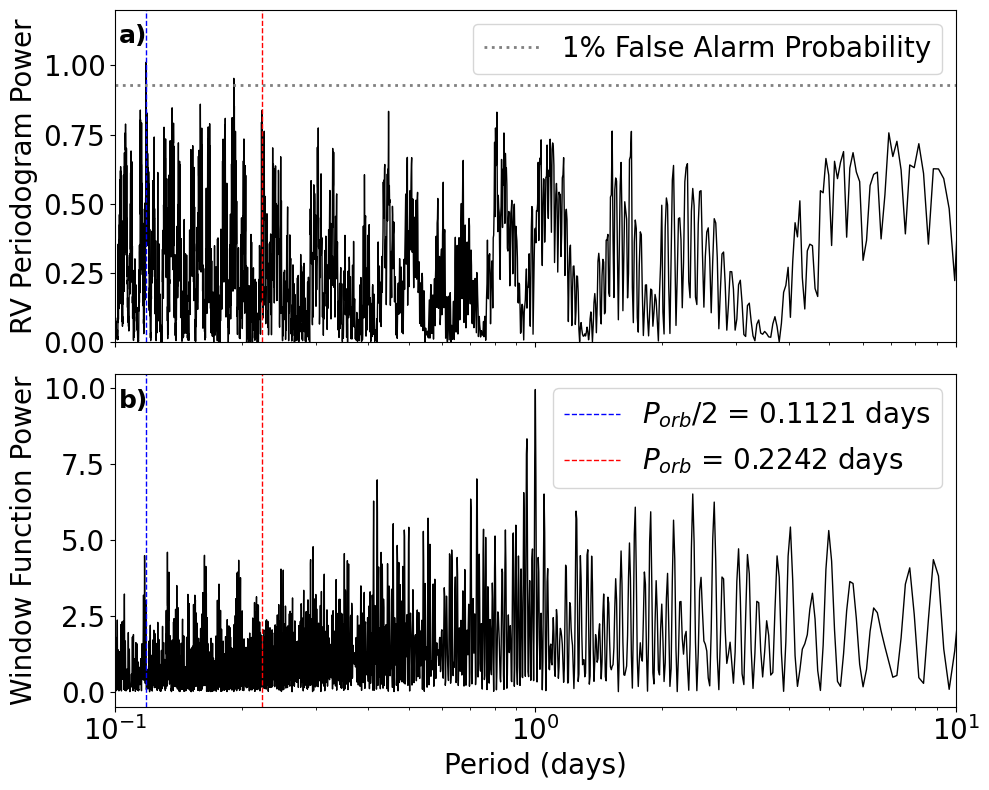

In [9]:
#Checking with the Window Function (Code from Gummi)

#We calculate the LS Periodogram.
L = LombScargle(df["time"].values,df["mnvel"].values,df["errvel"].values)
frequency, power = L.autopower(minimum_frequency=1/max_period,maximum_frequency=1/min_period)
periods = 1./frequency
false_alarm = LS.false_alarm_level(0.01, method='bootstrap')

#Function for Fourier Periodogram
def fourier_periodogram(x,y,f):
    """
    My implementation of using the classical discrete Fourier transform.
    Seems to be fairly fast ?
    
    INPUT:
        x - x values 
        y - y values
        f - frequency values to calculate the resulting periodogram
        
    EXAMPLE:
        
    NOTES:
        See Cochran 1996, EQ 16
        To get window function, then just put y = ones(len(x))
    """
    N = len(x)
    power = []
    for _f in f:
        cos = np.dot(y,np.cos(2.*np.pi*_f*x))**2.
        sin = np.dot(y,np.sin(2.*np.pi*_f*x))**2.
        _p = (cos+sin)/N
        power.append(_p)
    return np.array(power)

#We calculate the Window Function
w_power = fourier_periodogram(df["time"].values,np.ones(len(df["time"].values)),frequency)

#We create the figures.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

#We plot the Lomb-Scargle Periodogram
ax1.plot(periods, power, lw=1, color = "black")
ax1.text(0.005, 0.90, "a)", transform=ax1.transAxes, fontsize=18, fontweight="bold")
ax1.set_ylabel('RV Periodogram Power', fontsize = 20)
ax1.axvline(best_period, color = "blue", linestyle = "dashed", lw = 1)
ax1.axvline(0.224, color = "red", linestyle = "dashed", lw = 1)
ax1.axhline(false_alarm, color = "grey", linestyle = "dotted", lw = 2, label = "1% False Alarm Probability")
ax1.tick_params(axis = 'both', labelsize = 20)

#We plot the Window Function
ax2.plot(periods, w_power, lw=1, color = "black")
ax2.text(0.005, 0.90, "b)", transform=ax2.transAxes, fontsize=18, fontweight="bold")
ax2.set_xlabel('Period (days)', fontsize = 20)
ax2.set_ylabel('Window Function Power', fontsize = 20)
ax2.axvline(best_period, color = "blue", linestyle = "dashed", lw = 1, label = f"$P_{{orb}}$/2 = {0.2241957793/2:.4f} days")
ax2.axvline(0.224, color = "red", linestyle = "dashed", lw = 1, label = f"$P_{{orb}}$ = {0.2241957793:.4f} days")
ax2.tick_params(axis = 'both', labelsize = 20)

#We display the plots
ax1.set_xlim(0.1, 10)
ax2.set_xlim(0.1, 10)
ax1.set_ylim(0.0, 1.2)
#ax2.set_ylim(0.1, 10)
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.legend(fontsize = 20)
ax2.legend(fontsize = 20)
plt.tight_layout()

plt.savefig("toi_2431_periodogram.png", bbox_inches = "tight", dpi = 500)
plt.show()
plt.close()

In [10]:
malp = 374.86
mdel = -85.68

print(np.sqrt(malp**2 + mdel**2))

384.5270887726897
